In [ ]:
%matplotlib inline
import quantstats as qs
import numpy as np
import datetime as dt

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# Create random return data with a date index.
np.random.seed(42)
index = pd.date_range(end=dt.datetime.now(), periods=1000, freq='B')
stock = pd.Series(np.random.normal(0.001, 0.02, len(index)), index=index)

# show sharpe ratio
qs.stats.sharpe(stock)

np.float64(1.1239729896454933)

<Figure size 1000x600 with 0 Axes>

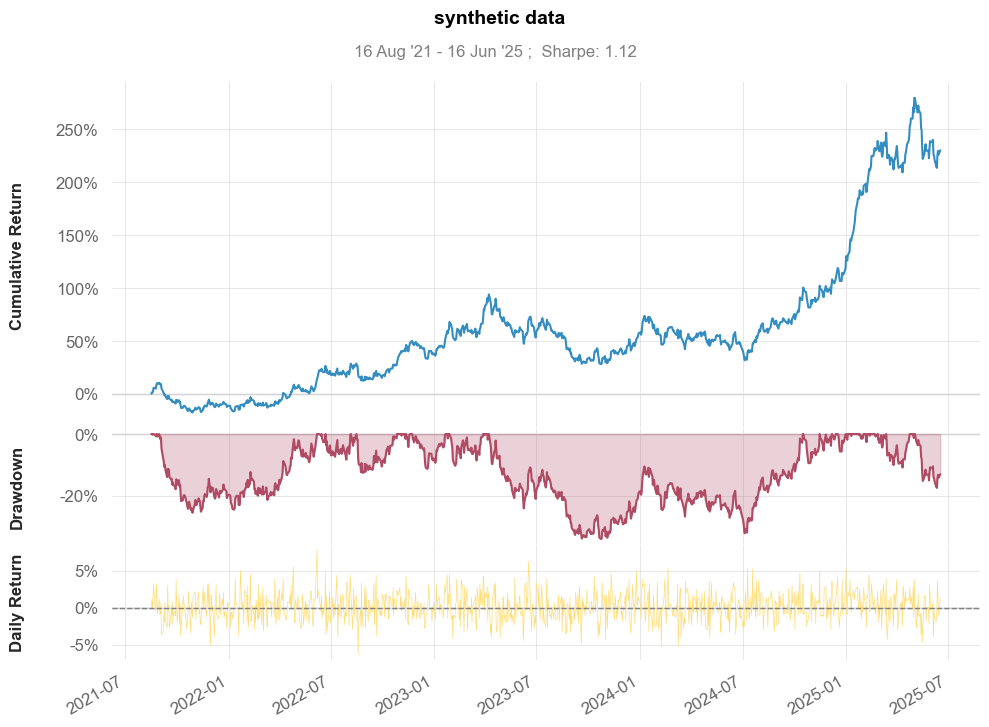

In [30]:
# 现在可以正常生成快照图
qs.plots.snapshot(stock, title='synthetic data', show=True)

                           Benchmark          Strategy
-------------------------  -----------------  -----------------
Start Period               2021-08-17         2021-08-17
End Period                 2025-06-16         2025-06-16
Risk-Free Rate             0.0%               0.0%
Time in Market             100.0%             100.0%

Cumulative Return          21.57%             230.29%
CAGR﹪                     3.58%              24.01%

Sharpe                     0.31               1.12
Prob. Sharpe Ratio         73.39%             98.77%
Smart Sharpe               0.31               1.12
Sortino                    0.46               1.71
Smart Sortino              0.45               1.7
Sortino/√2                 0.32               1.21
Smart Sortino/√2           0.32               1.2
Omega                      1.19               1.19

Max Drawdown               -50.97%            -33.99%
Longest DD Days            675                554
Volatility (ann.)          31.09%         

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-04-10,2023-10-23,2024-10-14,554,-33.986855,-33.586362
2,2021-08-31,2021-10-28,2022-06-03,277,-25.506838,-24.615973
3,2025-05-05,2025-06-10,2025-06-16,43,-17.444750,-17.061407
4,2022-08-16,2022-08-26,2022-10-25,71,-12.589336,-12.350562
5,2022-11-23,2022-12-19,2023-01-19,58,-11.262716,-10.971688


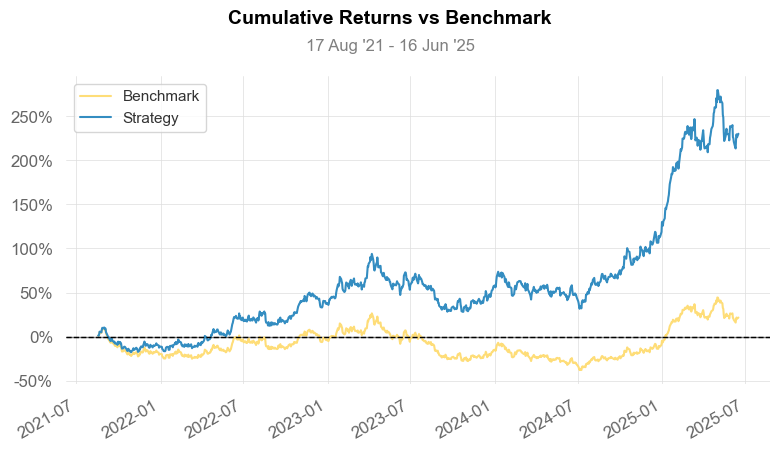

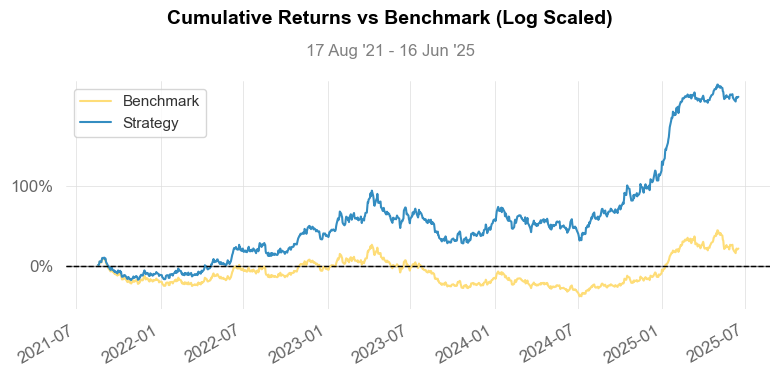

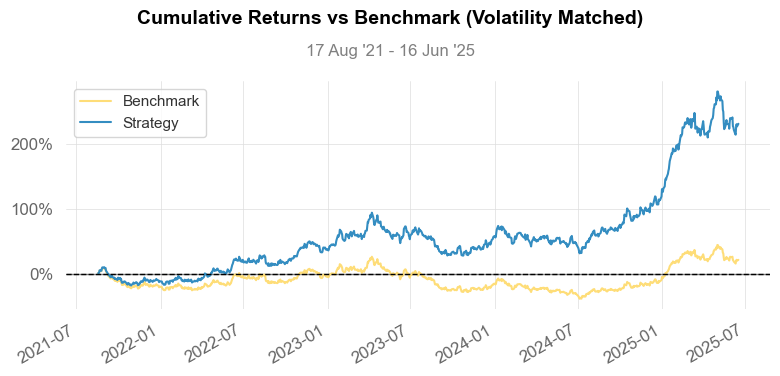

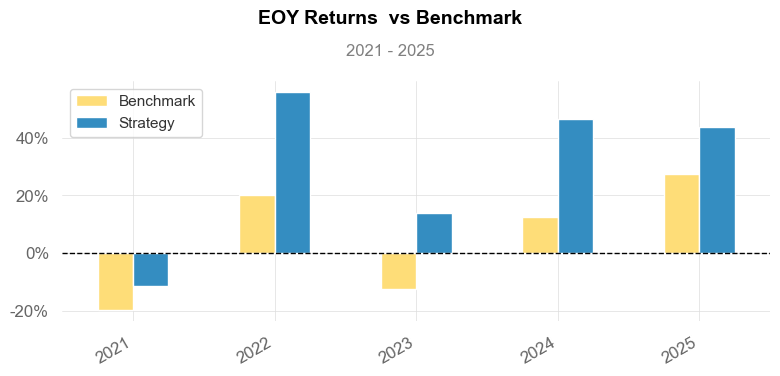

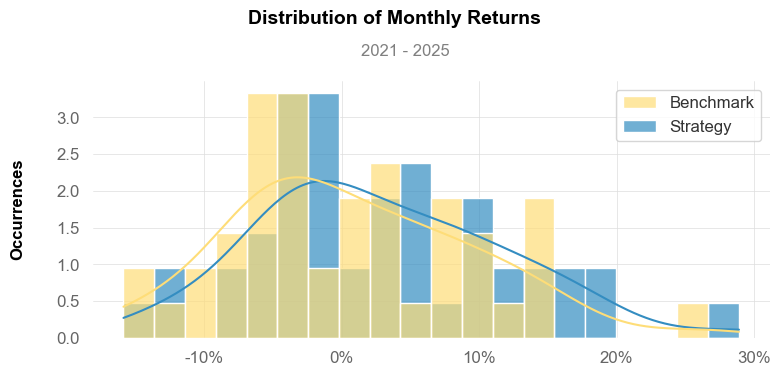

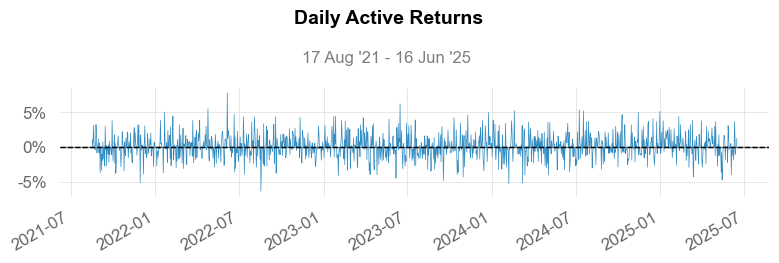

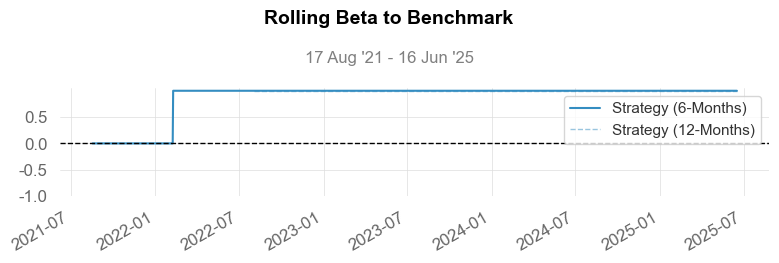

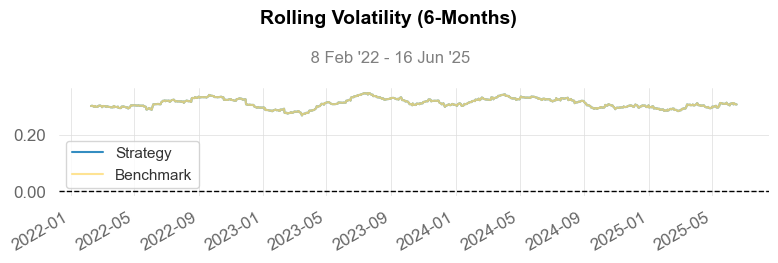

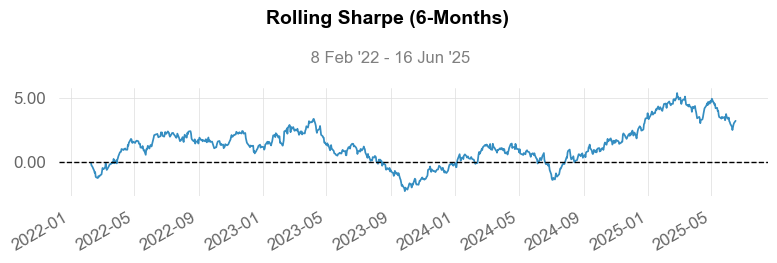

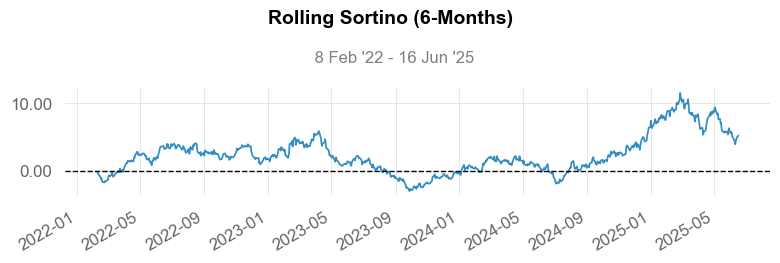

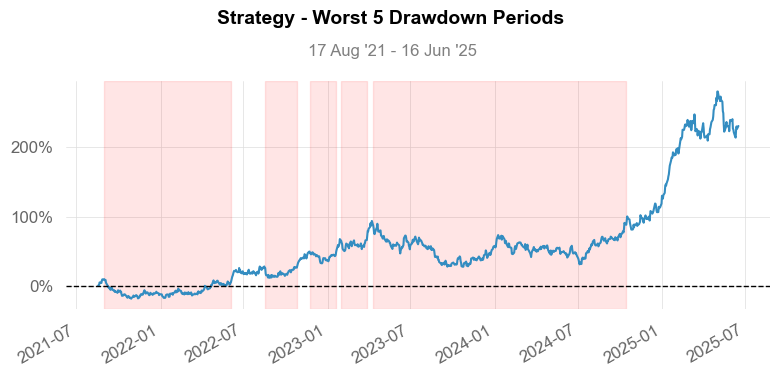

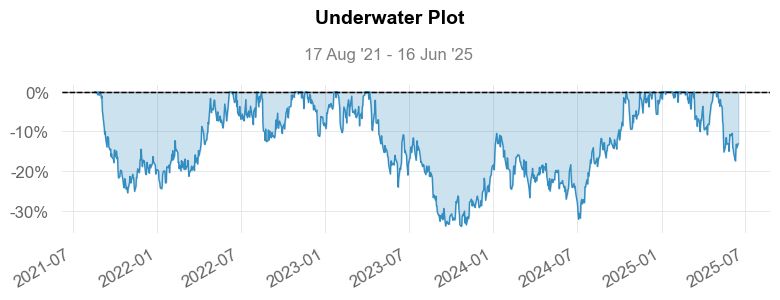

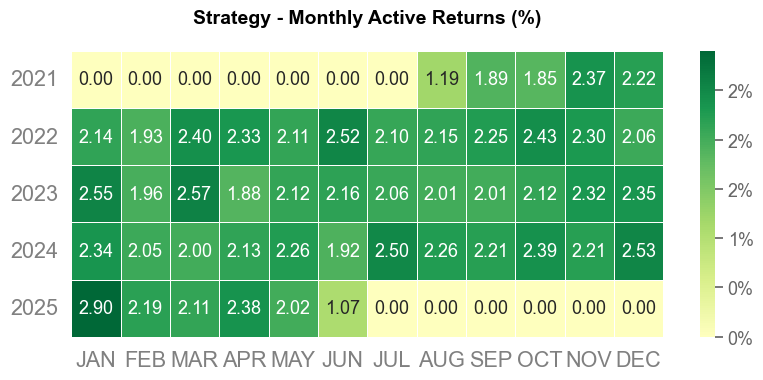

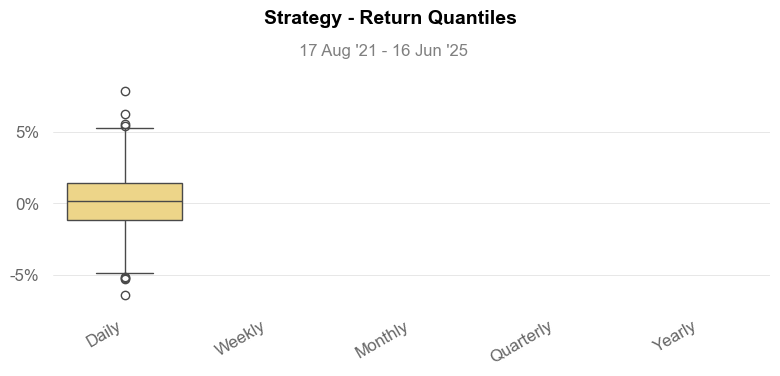

In [31]:
np.random.seed(42)
benchmark = pd.Series(np.random.normal(0.0, 0.02, len(index)), index=index)

qs.reports.full(stock, benchmark, output="/tmp/report.html")